In [11]:
# initialized connection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg
from scipy import stats

In [12]:
# read pwd string from save file
with open('postgrest_pwd.txt', 'r') as f:
    pwd = f.readline()

In [13]:
# read data from table to datatframe with Month form 201801
table = 'mis_cc_kpi_m'
with pg.connect(database='ktc', user='postgres', password=pwd) as con:
    df = pd.read_sql('select * from ' + table + ' where "month"::bigint >= 201801', con = con)

## Oss Credit card by month
### Approved performance

#### Finalized

In [14]:
df_gr = df.groupby(['month', 'channel', 'channel_sub'])
df_gr['finalized'].sum().unstack(0).applymap("{:,d}".format)

month                201801  201802  201803  201804  201805
channel channel_sub                                        
OSS     Direct       17,636  21,175  20,809  16,393  21,638
        OSS_Tele      1,184   1,275   1,158   1,495   1,744
Tele    Telesales     3,677   4,752   5,913   4,476   6,444

#### Approve-new

In [15]:
df_gr['appr_new'].sum().unstack(0).applymap("{:,d}".format)

month               201801 201802 201803 201804 201805
channel channel_sub                                   
OSS     Direct       6,582  7,912  7,620  6,027  8,402
        OSS_Tele       530    496    459    607    790
Tele    Telesales    1,472  1,544  1,931  1,538  2,124

#### % Appr-rate

In [16]:
(df_gr['appr'].sum()/df_gr['finalized'].sum()).unstack(0).applymap("{:.0%}".format)

month               201801 201802 201803 201804 201805
channel channel_sub                                   
OSS     Direct         41%    42%    40%    42%    44%
        OSS_Tele       46%    40%    41%    42%    52%
Tele    Telesales      43%    42%    41%    37%    35%

#### Credit limit new

In [17]:
(df_gr['credit_limit_new'].sum()/df_gr['appr_new'].sum()).unstack(0).applymap("{:,.0f}".format)

month                201801  201802  201803  201804  201805
channel channel_sub                                        
OSS     Direct       51,000  53,503  45,841  53,264  50,112
        OSS_Tele     54,630  43,952  40,033  36,219  43,983
Tele    Telesales    52,739  52,141  50,016  46,664  47,761

#### % active60D

In [18]:
(df_gr['active60'].sum()/df_gr['appr_new'].sum()).unstack(0).applymap("{:.0%}".format)

month               201801 201802 201803 201804 201805
channel channel_sub                                   
OSS     Direct         61%    62%    60%    54%    37%
        OSS_Tele       71%    75%    70%    66%    48%
Tele    Telesales      86%    86%    85%    79%    65%

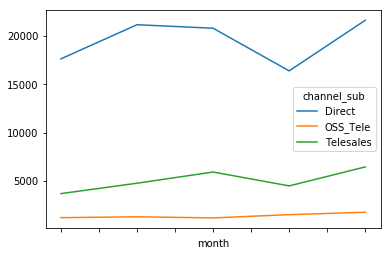

In [19]:
df.groupby(['channel_sub', 'month'])['finalized'].sum().unstack(0).plot()

In [20]:
df_gr[['finalized', 'appr_new']].sum().stack().unstack(0).applymap("{:,d}".format)

month                          201801  201802  201803  201804  201805
channel channel_sub                                                  
OSS     Direct      finalized  17,636  21,175  20,809  16,393  21,638
                    appr_new    6,582   7,912   7,620   6,027   8,402
        OSS_Tele    finalized   1,184   1,275   1,158   1,495   1,744
                    appr_new      530     496     459     607     790
Tele    Telesales   finalized   3,677   4,752   5,913   4,476   6,444
                    appr_new    1,472   1,544   1,931   1,538   2,124

In [21]:
# group by , sum, reset MultiIndex -> DataFrame
i = df_gr[['finalized', 'appr', 'appr_new']].sum().reset_index()
# create per apr from appr_new / finalzied
i['per_apr'] = (i['appr_new']/i['finalized'])
# Set style
i.style.format({'finalized':"{:,.0f}", 'appr':"{:,.0f}", 'appr_new':"{:,.0f}"}).format({'per_apr':"{:,.0%}"})

,month,channel,channel_sub,finalized,appr,appr_new,per_apr
0,201801,OSS,Direct,"17,636","7,300","6,582",37%
1,201801,OSS,OSS_Tele,"1,184",546,530,45%
2,201801,Tele,Telesales,"3,677","1,568","1,472",40%
3,201802,OSS,Direct,"21,175","8,883","7,912",37%
4,201802,OSS,OSS_Tele,"1,275",512,496,39%
5,201802,Tele,Telesales,"4,752","1,982","1,544",32%
6,201803,OSS,Direct,"20,809","8,400","7,620",37%
7,201803,OSS,OSS_Tele,"1,158",471,459,40%
8,201803,Tele,Telesales,"5,913","2,416","1,931",33%
9,201804,OSS,Direct,"16,393","6,918","6,027",37%


### Top Reason
#### OSS - top 5 Decline

In [22]:
# Filter only result == 'R' and channel == 'OSS'
# then group by month, result_description
# then size() 
# then reset MultiIndex to DataFrame
decline = (df[(df.result == 'R') & (df.channel == 'OSS')]
           .groupby(['month','result_description'])['finalized']
           .size().reset_index())

In [23]:
# create column rn = sort by finalized, decending order
# group by month, create rn (row_number) by cumcount()  +1
# query only rn (row_number) <= 5 (top 5)
# sort Dataframe by 'month and rn'

top_decline = (decline.assign(rn = decline.sort_values(['finalized'], ascending=False)
               .groupby(['month']).cumcount() + 1)
               .query('rn <= 5')
               .sort_values(['month', 'rn']))

In [24]:
# transform DataFrame to MultiIndex with pivot, sort by values in 201805
top_decline.pivot(index='result_description', columns='month', values='finalized').sort_values('201805', ascending = False)

month,201801,201802,201803,201804,201805
result_description,,,,,
D24,3115,3483,3554,2712,3521
D09,1403,1705,1780,1237,1681
D11,1780,1956,1509,1205,1504
D01,667,904,1075,766,974
D30,641,749,834,664,806


Another way of creating top decline

In [25]:
(df.query('result == "R" and channel == "OSS"')
 .groupby(['month', 'result_description'])
 .size().unstack(0).sort_values('201805', ascending = False).head(5))

month,201801,201802,201803,201804,201805
result_description,,,,,
D24,3115.0,3483.0,3554.0,2712.0,3521.0
D09,1403.0,1705.0,1780.0,1237.0,1681.0
D11,1780.0,1956.0,1509.0,1205.0,1504.0
D01,667.0,904.0,1075.0,766.0,974.0
D30,641.0,749.0,834.0,664.0,806.0


OSS - % top 5 decline

In [26]:
# Series of top decline by month and reason
decline = (df.query('result == "R" and channel == "OSS"')
 .groupby(['month', 'result_description'])
 .size())

# Series of finalized by month
finalized = (df.groupby('month').size())

# Series of top decline by month and reason / series of finalized by month, matching by month
(decline.div(finalized, level='month')
 .unstack(0)
 .sort_values('201805', ascending = False)
 .applymap("{:,.0%}".format).head(5))

month,201801,201802,201803,201804,201805
result_description,,,,,
D24,14%,13%,13%,12%,12%
D09,6%,6%,6%,6%,6%
D11,8%,7%,5%,5%,5%
D01,3%,3%,4%,3%,3%
D30,3%,3%,3%,3%,3%


Oss - Top 5 cancel & % top 5 cancel

In [27]:
oss_cancel = (df.query('result == "C" and channel == "OSS"')
              .groupby(['month', 'result_description']).size())
oss_finaize = (df.query('channel == "OSS"').groupby('month').size())

oss_cancel.unstack(0).sort_values('201805', ascending = False).head(5).applymap("{:,.0f}".format)

month,201801,201802,201803,201804,201805
result_description,,,,,
C02,708,830,480,343,588
C04,402,547,486,423,528
C74,160,182,217,249,409
C01,224,213,253,274,358
C03,109,118,154,245,198


In [28]:
(oss_cancel.div(oss_finaize, level = 'month').unstack(0).sort_values('201805', ascending = False)
 .head(5).applymap("{:,.0%}".format))

month,201801,201802,201803,201804,201805
result_description,,,,,
C02,4%,4%,2%,2%,3%
C04,2%,2%,2%,2%,2%
C74,1%,1%,1%,1%,2%
C01,1%,1%,1%,2%,2%
C03,1%,1%,1%,1%,1%


### Demographic group

In [29]:
%matplotlib inline

month
201801    AxesSubplot(0.125,0.125;0.775x0.755)
201802    AxesSubplot(0.125,0.125;0.775x0.755)
201803    AxesSubplot(0.125,0.125;0.775x0.755)
201804    AxesSubplot(0.125,0.125;0.775x0.755)
201805    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

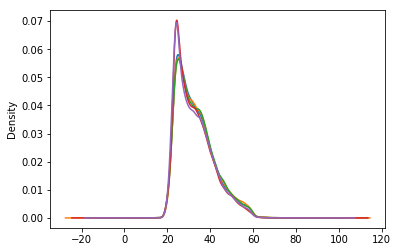

In [30]:
df.loc[df.age > 0].groupby('month')['age'].plot.density()

In [31]:
# use group by
df.groupby(['channel','bkk_upc']).size().unstack(0)

channel,OSS,Tele
bkk_upc,,
BKK,49922,14099
UPC,54544,11155


In [32]:
# use cross tab
pd.crosstab(df.bkk_upc, df.channel)

channel,OSS,Tele
bkk_upc,,
BKK,49922,14099
UPC,54544,11155


array([<matplotlib.axes._subplots.AxesSubplot object at 0x2C6C7590>,
      dtype=object)

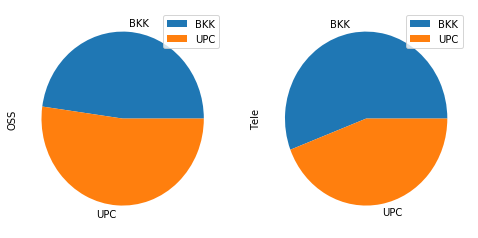

In [33]:
%matplotlib inline
df.groupby(['channel','bkk_upc']).size().unstack(0).plot.pie(subplots = True, figsize=(8,4))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2CCB0CB0>,
      dtype=object)

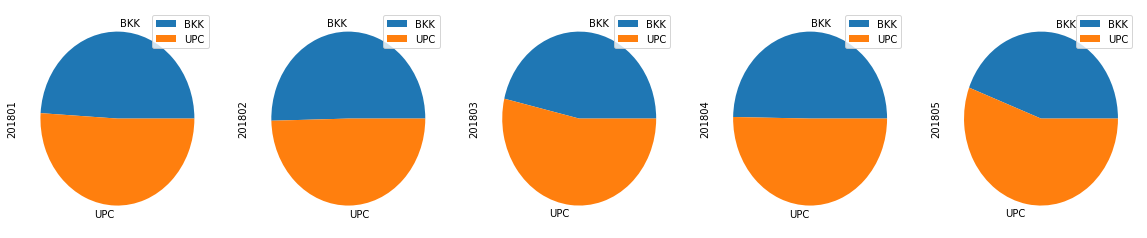

In [34]:
df.groupby(['channel','month','bkk_upc']).size().unstack([0,1])['OSS'].plot.pie(subplots = True, figsize=(20,4))

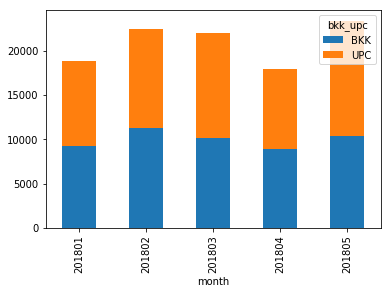

In [35]:
df.groupby(['channel','month','bkk_upc']).size().unstack([0,2])['OSS'].plot.bar(stacked = True)

### Statistical inference
##### T-Test
Non paired t-test pulled varience between average age last month vs last 2 month

In [36]:
# OSS avg age by month
df.query('channel == "OSS" and age > 0').groupby('month')['age'].mean()

month
201801    33.452415
201802    33.449354
201803    33.254700
201804    32.491335
201805    32.431785
Name: age, dtype: float64

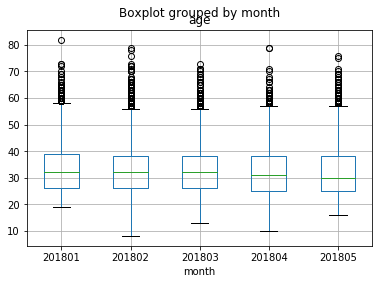

In [37]:
# boxplot Oss avg age by month
df.query('channel == "OSS" and age > 0').boxplot(column='age', by='month')

In [38]:
def last_2_month(df):
    month_list = df.month.unique()
    month_list.sort()
    try:
        return month_list[-1:-3:-1]  # list of last month and last 2 month
    except:
        print("Error ".format(month_list))
        return None

In [39]:
def t_test_last_mom(df, var):
    # find last month and last 2 month
    months = last_2_month(df)
    
    # Pair-wised t-test differenc in mean
    var_last = df.loc[(df.channel == "OSS") & (df.month == months[0]), [var]]
    var_last_2 = df.loc[(df.channel == "OSS") & (df.month == months[1]), [var]]
    test = stats.ttest_ind(var_last, var_last_2)
    
    # print test result
    print("{0} t-test month {1} with month {2}".format(var, months[0], months[1]))
    print("p-valus : {:.5f}".format(test.pvalue[0]))
    if test.pvalue[0] < 0.05:
        print("reject H0, {0} significantly difference {1} and {2}".format(var, months[0], months[1]))
    else:
        print("accept H0, {0} not significantly difference {1} and {2}".format(var, months[0], months[1]))
    return None

In [40]:
t_test_last_mom(df, "monthly_salary")

monthly_salary t-test month 201805 with month 201804
p-valus : 0.02263
reject H0, monthly_salary significantly difference 201805 and 201804


##### Chisq-test
Goodness to fit test top reject between last month whith last 2 month as base distribution

In [41]:
# create cross tabulation data for calculation
top5_decline_monthly = \
(df.query('channel == "OSS" and result == "R"')
 .groupby(['month', 'result_description']).size().unstack(0)
 .sort_values('201805', ascending = False).head(5).stack().unstack(0))

In [42]:
top5_decline_monthly

result_description,D24,D09,D11,D01,D30
month,,,,,
201801,3115.0,1403.0,1780.0,667.0,641.0
201802,3483.0,1705.0,1956.0,904.0,749.0
201803,3554.0,1780.0,1509.0,1075.0,834.0
201804,2712.0,1237.0,1205.0,766.0,664.0
201805,3521.0,1681.0,1504.0,974.0,806.0


In [43]:
# select expected distribution as last 2 month
# select observed distribution as last month
exp_dist = top5_decline_monthly.iloc[top5_decline_monthly.shape[0]-2]
obs_dist = top5_decline_monthly.iloc[top5_decline_monthly.shape[0]-1]

# chisq goodness of fit
# since sample 201804 not equal 201805 then use % contribution by month to test goodness of fit
test = stats.chisquare(obs_dist/obs_dist.sum(), exp_dist/exp_dist.sum())
print(test)

# test result
if test.pvalue < 0.05:
    print('Reject H0 : the distribution are difference')
else:
    print('Accept H0 : the distribution are same')

Power_divergenceResult(statistic=0.0011227267827691684, pvalue=0.9999998424945262)
Accept H0 : the distribution are same


In [44]:
# another way to count top 5 rejects by month
(pd.crosstab(df.query('channel == "OSS" and result == "R"')['month'], 
            df.query('channel == "OSS" and result == "R"')['result_description'])
 .sort_values(by = '201805', axis = 1, ascending = False).transpose().head().transpose())

result_description,D24,D09,D11,D01,D30
month,,,,,
201801,3115,1403,1780,667,641
201802,3483,1705,1956,904,749
201803,3554,1780,1509,1075,834
201804,2712,1237,1205,766,664
201805,3521,1681,1504,974,806
